In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    

with open('dataset-tp (1).pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights
n_samples = X.shape[0]
n_features = X.shape[1]

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007278]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06


In [27]:
# create an util to visualize a weight tensor showing the idx, value pairs
def visualize_weights(weights: torch.Tensor):
    length = weights.shape[0]
    idxs = torch.arange(length)

    print("torch.Tensor: ", [(f"{idx.item()}: {weight.item():.2e}") for idx, weight in zip(idxs, weights)])

In [28]:
 # Fit model with first n samples
surrogate = Lasso(alpha=0.0003, max_iter=10000)
X_batch, y_batch, w_batch = next(iter(DataLoader(ds, batch_size=n_samples)))
surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())

# Get coefficients
phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
phi0 = surrogate.intercept_  # intercept
beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

print(f"Intercept (phi0): {phi0:.6f}")
print(f"Coefficients (phis): {visualize_weights(phis)}, shape={phis.shape}")

Intercept (phi0): 0.000600
torch.Tensor:  ['0: 0.00e+00', '1: 0.00e+00', '2: 3.60e-04', '3: 6.94e-04', '4: 6.55e-04', '5: 1.90e-04', '6: 3.32e-04', '7: 9.34e-05', '8: 0.00e+00', '9: 0.00e+00', '10: 0.00e+00', '11: 1.01e-04', '12: 0.00e+00', '13: 0.00e+00', '14: 8.45e-05', '15: 0.00e+00', '16: 3.32e-05', '17: 1.04e-05', '18: 0.00e+00', '19: 4.02e-05', '20: 4.97e-05', '21: 0.00e+00', '22: 1.07e-06', '23: 0.00e+00', '24: 2.13e-06', '25: 0.00e+00', '26: 0.00e+00', '27: 0.00e+00', '28: 0.00e+00', '29: 0.00e+00', '30: 0.00e+00', '31: 0.00e+00', '32: 0.00e+00', '33: 0.00e+00', '34: 0.00e+00', '35: 0.00e+00', '36: 0.00e+00', '37: 0.00e+00', '38: 0.00e+00', '39: 0.00e+00', '40: 1.79e-05', '41: 0.00e+00', '42: 0.00e+00', '43: 0.00e+00', '44: 0.00e+00', '45: 0.00e+00', '46: 0.00e+00', '47: 0.00e+00', '48: 0.00e+00', '49: 0.00e+00', '50: 0.00e+00', '51: 0.00e+00', '52: 0.00e+00', '53: 0.00e+00', '54: 0.00e+00', '55: 0.00e+00', '56: 0.00e+00', '57: 0.00e+00', '58: 0.00e+00', '59: 0.00e+00', '60: 0.

In [29]:
# sort features by mean value of y for each feature where X[:, i] != 0
mean_y = torch.zeros(n_features)
for i in range(n_features):
    mean_y[i] = y[X[:, i] != 0].mean() if (X[:, i] != 0).any() else -100000.0

sorted_indices_mean_y = torch.argsort(mean_y, descending=True)
print(f"Sorted indices by mean y: {sorted_indices.tolist()}")

Sorted indices by mean y: [164, 3, 4, 213, 2, 6, 5, 94, 212, 11, 171, 7, 127, 159, 14, 75, 63, 20, 19, 16, 80, 85, 90, 40, 62, 17, 64, 112, 117, 24, 161, 22, 65, 261, 262, 260, 263, 264, 259, 256, 258, 265, 266, 257, 249, 267, 268, 281, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 269, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 220, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 232, 219, 218, 217, 216, 215, 214, 211, 210, 209, 208, 243, 254, 253, 252, 251, 250, 304, 248, 247, 246, 245, 244, 255, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 349, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 361, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 372, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 338, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 192, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 316, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 327, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 293, 326, 325, 324

### first indices belong to the assumed most relevant supervoxels

In [30]:
# sort features by their coefficients
sorted_indices_coefs = torch.argsort(phis.abs(), descending=True)
print(f"Sorted indices by absolute value of coefficients: {sorted_indices.tolist()}")

Sorted indices by absolute value of coefficients: [164, 3, 4, 213, 2, 6, 5, 94, 212, 11, 171, 7, 127, 159, 14, 75, 63, 20, 19, 16, 80, 85, 90, 40, 62, 17, 64, 112, 117, 24, 161, 22, 65, 261, 262, 260, 263, 264, 259, 256, 258, 265, 266, 257, 249, 267, 268, 281, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 269, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 220, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 232, 219, 218, 217, 216, 215, 214, 211, 210, 209, 208, 243, 254, 253, 252, 251, 250, 304, 248, 247, 246, 245, 244, 255, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 349, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 361, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 372, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 338, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 192, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 316, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 327, 337, 336, 335, 334, 333, 332, 331, 330, 329,

Feature 164 (mean y=0.006408) is ranked 1 in the coefficients position_in_coefs_ranking
Feature 213 (mean y=0.006215) is ranked 4 in the coefficients position_in_coefs_ranking
Feature 212 (mean y=0.006192) is ranked 9 in the coefficients position_in_coefs_ranking
Feature 171 (mean y=0.006175) is ranked 11 in the coefficients position_in_coefs_ranking
Feature 255 (mean y=0.006174) is ranked 107 in the coefficients position_in_coefs_ranking
Feature 94 (mean y=0.006170) is ranked 8 in the coefficients position_in_coefs_ranking
Feature 127 (mean y=0.006144) is ranked 13 in the coefficients position_in_coefs_ranking
Feature 64 (mean y=0.006137) is ranked 27 in the coefficients position_in_coefs_ranking
Feature 366 (mean y=0.006130) is ranked 159 in the coefficients position_in_coefs_ranking
Feature 315 (mean y=0.006129) is ranked 165 in the coefficients position_in_coefs_ranking


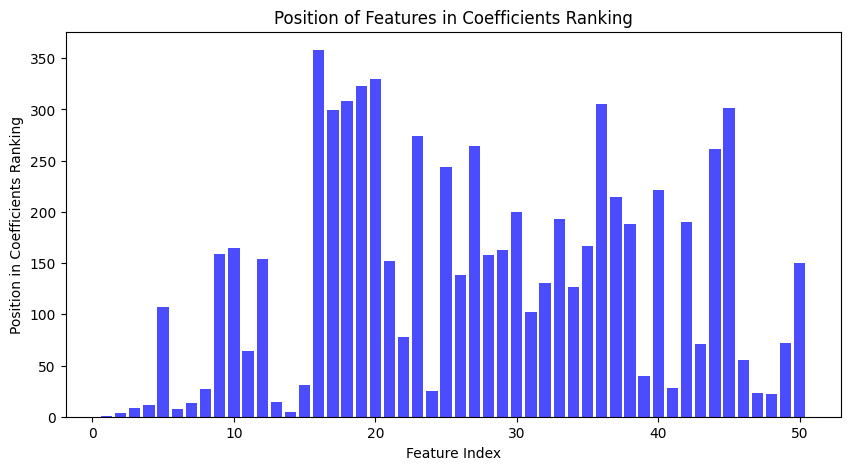

In [36]:
# draw the position of the highest ranked features according to the mean value of y, in the order of the coefficients
n_best = 10
for i in range(n_best):
    idx = sorted_indices_mean_y[i].item()
    position_in_coefs_ranking = (sorted_indices_coefs == idx).nonzero(as_tuple=True)[0].item()
    print(f"Feature {idx} (mean y={mean_y[idx].item():.6f}) is ranked {position_in_coefs_ranking + 1} in the coefficients position_in_coefs_ranking")

plot_first = 50
idx = sorted_indices_mean_y[:plot_first].numpy()
positions_in_coefs_ranking = [sorted_indices_coefs.tolist().index(i) + 1 for i in idx]
plt.figure(figsize=(10, 5))
plt.bar(range(1, plot_first+1), positions_in_coefs_ranking, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Position in Coefficients Ranking')
plt.title('Position of Features in Coefficients Ranking')
plt.show()